## Model Evaluation - One vs Rest

Fitting models to data after performing feature selection. This notebook contains models and evaluation methods applicable to multiclass and binary classification problems, i.e problems where a given sample belongs to only one class. 

In [1]:
import pandas as pd
import numpy as np
import boto3
import s3fs
import os
import sys
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import xgboost as xgb
import warnings
import itertools
from scipy import stats
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator

Helper functions for evaluation and plotting

In [2]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

In [3]:
# We read in a dataset that has already been feature selected
# To obtain, just run the feature selection notebook and configure filepaths
filepath = "s3://voightlab-data/t2d/FeatureSelected/chi2/"

X_train = pd.read_csv(filepath + "X_train.csv", index_col=0)
y_train = pd.read_csv(filepath + "y_train.csv", index_col=0, header=None)
X_test = pd.read_csv(filepath + "X_test.csv", index_col=0)
y_test = pd.read_csv(filepath + "y_test.csv", index_col=0, header=None)

In [4]:
X_train.head()
X_test.head()

,Ishikawa_ChIP-seq_YY1_ENCSR000BSY_ENCFF001TVY_ENCFF001TVX_intersect.bed,H1-hESC_ChIP-seq_BACH1_ENCFF002CQP.bed,E004-H3K79me1.gappedPeak,E004-H3K79me2.gappedPeak,E008-H3K79me2.gappedPeak,E087-H3K27ac.gappedPeak,E118-H3K79me2.gappedPeak,E122-H4K20me1.gappedPeak,PE_Active_Enhancers_hg19.bed,Islets.stretchEnhancers.bed,...,PANC.ISLT-EnhWk,PDX1,GSE64233_p65_V_final.bed,GSM1208731_batch2_chrom1_LoVo_E2F8_PassedQC_peaks_hg19.bed,GSM1208739_batch2_chrom1_LoVo_ETV7_PassedQC_peaks_hg19.bed,GSM1208788_batch2_chrom1_LoVo_RARG_PassedQC_peaks_hg19.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,0,1,1,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,1,53
1,0,1,0,0,0,1,0,0,1,1,...,1,1,0,0,0,0,1,1,1,18
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,37
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2


In [5]:
# Normalize the columns that are continuous to fall between 0 and 1
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [6]:
X_train.head()

,Ishikawa_ChIP-seq_YY1_ENCSR000BSY_ENCFF001TVY_ENCFF001TVX_intersect.bed,H1-hESC_ChIP-seq_BACH1_ENCFF002CQP.bed,E004-H3K79me1.gappedPeak,E004-H3K79me2.gappedPeak,E008-H3K79me2.gappedPeak,E087-H3K27ac.gappedPeak,E118-H3K79me2.gappedPeak,E122-H4K20me1.gappedPeak,PE_Active_Enhancers_hg19.bed,Islets.stretchEnhancers.bed,...,PANC.ISLT-EnhWk,PDX1,GSE64233_p65_V_final.bed,GSM1208731_batch2_chrom1_LoVo_E2F8_PassedQC_peaks_hg19.bed,GSM1208739_batch2_chrom1_LoVo_ETV7_PassedQC_peaks_hg19.bed,GSM1208788_batch2_chrom1_LoVo_RARG_PassedQC_peaks_hg19.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013831
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005533
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.048409
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001383


### Logistic Regression

In [7]:
log_model = LogisticRegressionCV(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000,
                                 n_jobs=-1)

log_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [8]:
print("Training Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_train, y_train, threshold=0.5)

Training Dataset Logistic Model Performance:
 Precision: 0.26547231270358307
 Recall: 0.5379537953795379
 Accuracy: 0.7213578500707214


In [9]:
print("Test Dataset Logistic", end=" ")
log_metrics = ev.summarize_performance(log_model, X_test, y_test, threshold=0.5, return_stats=True)

Test Dataset Logistic Model Performance:
 Precision: 0.27586206896551724
 Recall: 0.5789473684210527
 Accuracy: 0.7227443609022557


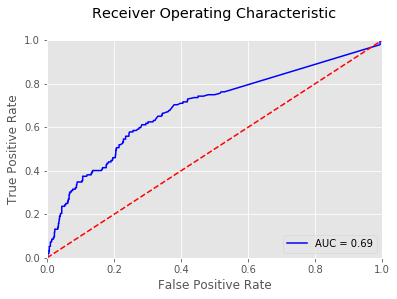

In [10]:
ev.plot_roc_curve(log_model, X_test, y_test)

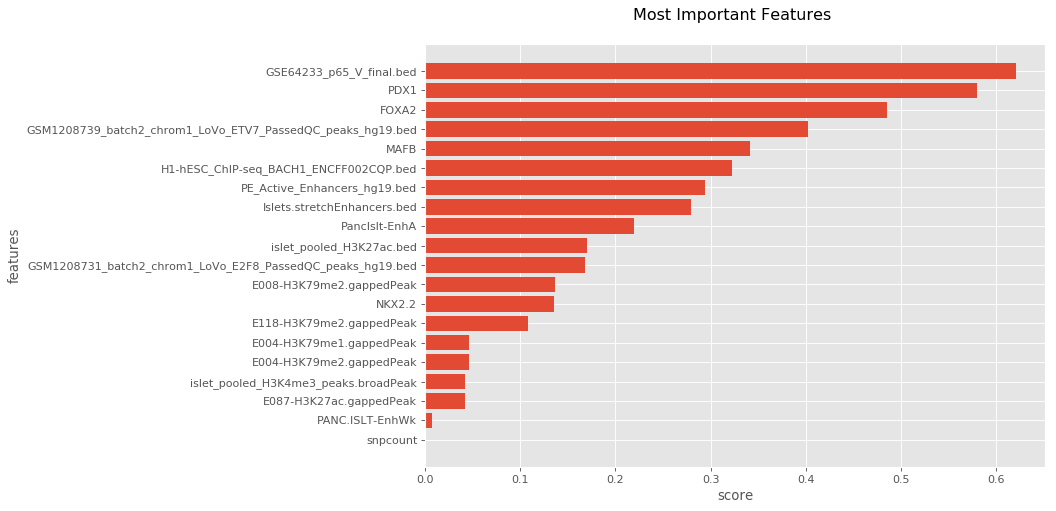

In [11]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)[0]

### Support Vector Machine 

In [12]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=5000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [13]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_train, y_train, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.27454545454545454
 Recall: 0.49834983498349833
 Accuracy: 0.7402168788307402


In [14]:
print("Test Dataset SVM", end=" ")
svm_metrics = ev.summarize_performance(svm_model, X_test, y_test, threshold=0.5, return_stats=True)

Test Dataset SVM Model Performance:
 Precision: 0.0
 Recall: 0.0
 Accuracy: 0.8571428571428571


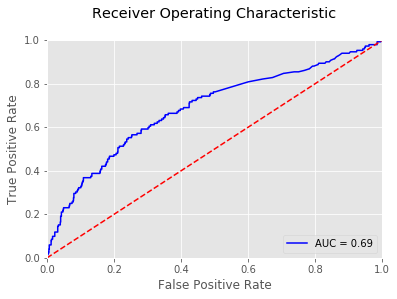

In [15]:
ev.plot_roc_curve(svm_model, X_test, y_test)

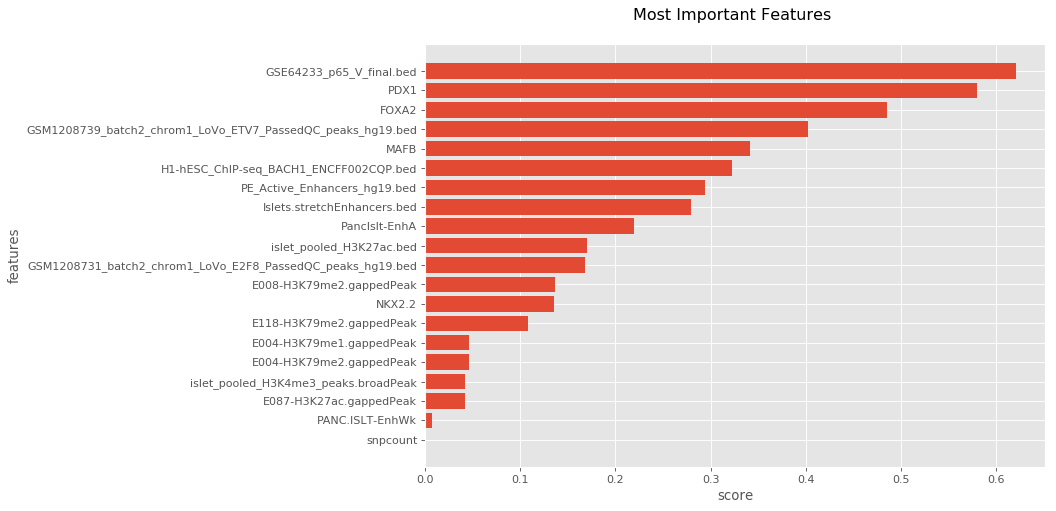

In [16]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)

### Random Forest

In [17]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', oob_score=True)

# Parameter grid for grid search
rf_params = {'n_estimators': stats.randint.rvs(100, 1000, size=50),
			 'max_depth': stats.randint.rvs(2, len(X_train.columns) - 2, size=15), 
             'min_samples_leaf': stats.uniform(0, 0.4),
             'class_weight':['balanced', 'balanced_subsample']}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [ ]:
# Grid search to iteratively search parameter space
rf_grid = RandomizedSearchCV(rf_model, n_iter=100, param_distributions=rf_params,
                             cv=cv, scoring=scoring, refit='roc_auc')
rf_grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

In [ ]:
ev.summarize_performance(rf_grid, X_train, y_train, proba=True)

In [ ]:
rf_metrics = ev.summarize_performance(rf_grid, X_test, y_test, proba=True, return_stats=True)

In [ ]:
# Plot feature importance
coefs = rf_grid.best_estimator_.feature_importances_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=True)

In [ ]:
ev.plot_roc_curve(rf_grid, X_test, y_test)

### Gradient Boosted Trees

In [ ]:
xgtrain = X_train.values
xgtrain_target = y_train.values
xgtest = X_test.values
xgtest_target = y_test.values

In [ ]:
 # parameters to be tries in the grid search
cv_params = {'max_depth': [2, 3,5,7,10, 15, 20], 'min_child_weight': [1,2,3,4,5], 'scale_pos_weight':[2, 5, 7, 9]}   
#other parameters, fixed for the moment 
fix_params = {'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary:logistic','silent':1}   
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5)

In [ ]:
# Trying to find best params for max depth and child weight
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

In [ ]:
best_depth = csv.best_params_['max_depth']
best_child_weight = csv.best_params_['min_child_weight']
best_pos_weight = csv.best_params_['scale_pos_weight']

In [ ]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 150, 'objective': 'binary:logistic',
              'max_depth': best_depth, 'min_child_weight':best_child_weight, 'scale_pos_weight':best_pos_weight}

In [ ]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

In [ ]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
fix_params['max_delta_step'] = csv.best_params_['max_delta_step']
fix_params['subsample'] = csv.best_params_['subsample']

In [ ]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.cv_results_
csv.best_params_

In [ ]:
fix_params['learning_rate'] = csv.best_params_['learning_rate']
params_final =  fix_params
params_final['eval_metric'] = 'auc'
params_final['silent'] = 1
print(params_final)

In [ ]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)

xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

In [ ]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10,7), dpi=80)
#  fig = plt.figure(num=None, figsize=(10, 7), dpi=80)
xgb.plot_importance(xgb_final, max_num_features=25, height=0.8, ax=ax)
plt.show()

In [ ]:
ev.plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False, model_type='xgboost')

In [ ]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.19
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
ev.plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = ev.summarize_cmatrix(cm);

xgb_metrics = [pr, tpr, accuracy_score( y_test,y_pred)]

In [ ]:
'''
These functions plot roc curves for model performance for each of the specified parameters to plot_roc.
Pass the name of the parameter to name_par and pass values to test to list_par
'''
def get_curves(X_train, y_train, X_val, y_val, pars):
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec


def gen_curves(X_train, y_train, X_val, y_val, pars):
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_train, y_train, X_val, y_val, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec

In [ ]:
def plot_roc(X_train, y_train, X_val, y_val, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,7));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_train, y_train, X_val, y_val, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.5, 0.95])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.5, 1])
    plt.show()

In [ ]:
par = params_final
plot_roc(xgtrain, xgtrain_target, xgtest, xgtest_target, par, 'max_depth', [3,4,5,7,10,15])

In [ ]:
# Take a look at current params
par

In [ ]:
par['max_depth'] = 3
par['learning_rate'] = 0.05
par['n_estimators'] = 200
par['scale_pos_weight'] = 6

In [ ]:
# Based on what we see with the graphs, re run xgboost with the params we think might help
xgb_final = xgb.train(par, xgdmat_train, num_boost_round = 100)
plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False)

### Model Comparison

Lets visualize summary statistics for each of the model types we've tried to see how they stack up to one another. To do this I've made use of the plot_compare method in Evaluator.py. More details on params are provided in the class file. 

In [ ]:
results = [log_metrics, svm_metrics, rf_metrics, xgb_metrics]
labels = ["Precision", "Recall", "Accuracy"]
titles = ["Logistic Regression", "SVM", "Random Forest", "XGboost"]

In [ ]:
ev.plot_compare(results, labels, xlabel='Metrics', ylabel='%', titles=titles)